In [1]:
import matplotlib.pyplot as plt
import numpy as np

In [3]:
suffix = "all_100"
base_dir = f"/home/ccl/Code/svox2/opt/ckpt_auto/128_to_256_scannerf_{suffix}/airplane1/test_renders"
c2ws = np.load(f"{base_dir}/c2ws.npy")


c2ws = np.load(f"{base_dir}/c2ws.npy")
c2ws_train = np.load(f"{base_dir}/c2ws_train.npy")

center_pt = np.mean(c2ws[:,:3,3], axis=0)
directions_train = (c2ws_train[:,:3,3] - center_pt)
directions = (c2ws[:,:3,3] - center_pt)
directions_train = directions_train / np.linalg.norm(directions_train, keepdims=True, axis=1)
directions = directions / np.linalg.norm(directions, keepdims=True, axis=1)
cos_dist = np.matmul(directions, directions_train.transpose())
closest_train_index = np.argmax(cos_dist, axis=1)
cos_dist = np.max(cos_dist, axis=1)
angles = np.arccos(cos_dist)
abs_angles = np.arctan2(directions[:,0], directions[:,2])

def get_metrics(base_dir):
    psnr = np.load(f"{base_dir}/psnr.npy")
    psnr_train = np.load(f"{base_dir}/psnr.npy")
    return psnr, psnr_train
    
# suffixes = ["all_100", "all_250", "all_500", "all"]
suffixes = ["all_100","all"]
psnrs = []
psnrs_train = []

for suffix in suffixes:
    base_dir2 = f"/home/ccl/Code/svox2/opt/ckpt_auto/128_to_256_scannerf_{suffix}/airplane1/test_renders"

    psnr, psnr_train = get_metrics(base_dir2)
    psnrs.append(psnr)
    psnrs_train.append(psnr_train)

psnrs = np.stack(psnrs)
psnrs_train = np.stack(psnrs_train)
best_psnr = np.max(psnrs, axis=0)
best_psnr_idx = np.argmax(psnrs, axis=0)

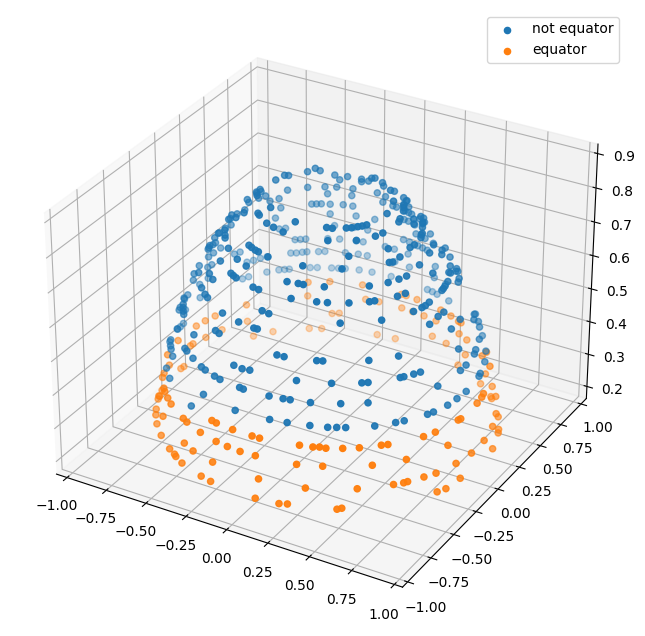

In [14]:
fig = plt.figure(figsize=(10,8))
# ax = fig.add_subplot()
ax = fig.add_subplot(projection='3d')
equator_threshold = -0.4
equator = np.where(c2ws[:,1,3] > equator_threshold)
not_equator = np.where(c2ws[:,1,3] < equator_threshold)
ax.scatter(c2ws[not_equator,0,3],c2ws[not_equator,2,3],-c2ws[not_equator,1,3], label="not equator")
ax.scatter(c2ws[equator,0,3],c2ws[equator,2,3],-c2ws[equator,1,3], label="equator")
ax.legend()
fig.savefig("/home/ccl/Downloads/plots/EQUATOR_FILTER.jpeg")

psnr_filtered = psnrs[:,equator][:,0,:]
c2ws_filtered = c2ws[equator]
abs_angles_filtered = abs_angles[equator]
angles_filtered = angles[equator]

[[379 414 378 413 377 459 412 492 470 458 411 469 471 421 422 493 423 359
  361 391 472 390 362 495 478 381 474 468 494 491 484 419 496 490 363 420
  499 475 436 358 389 485 432 488 405 435 406 497 407 399 498 410 467 473
  445 446 440 392 434 476 455 442 450 448 393 479 415 456 461 489 439 409
  367 371 376 438 462 366 482 433 457 487 424 437 454 460 375 425 430 443
  404 417 403 388 398 486 477 402 400 464 368 418 372 453 401 365 441 374
  447 426 394 395 396 373 369 380 370 416 427 428 481 444 463 408 397 360
  431 483 465 449 429 466 480 452 451]
 [495 478 468 492 499 491 494 381 490 472 496 477 471 488 363 479 475 358
  484 474 445 489 482 436 473 389 467 446 469 419 435 498 461 481 476 420
  480 442 462 448 405 458 485 438 432 455 443 433 371 460 388 450 444 497
  402 434 487 437 447 396 401 456 440 470 403 365 406 457 399 390 428 407
  370 404 391 417 439 493 463 422 408 394 393 400 398 483 427 424 441 395
  392 418 367 372 374 459 423 373 466 449 486 425 380 465 369 366 368 413

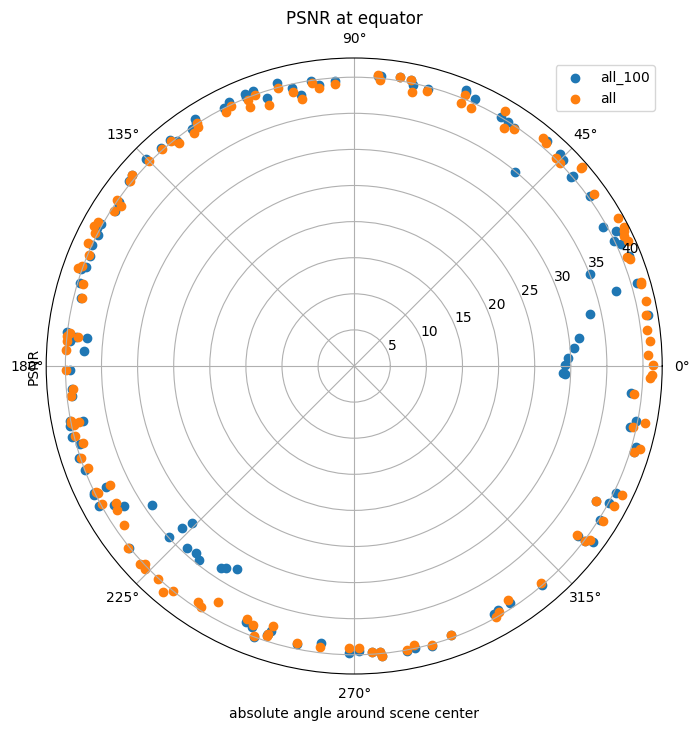

In [36]:
fig = plt.figure(figsize=(10,8))
# ax = fig.add_subplot()
ax = fig.add_subplot(projection='polar')
plt.ylabel("PSNR")
plt.xlabel("absolute angle around scene center")
plt.title("PSNR at equator")
x = abs_angles_filtered
for i, suffix in enumerate(suffixes):
    y = psnr_filtered[i]
    idx = np.argsort(x)
    # ax.plot(x[idx], y[0,idx], label=f"{suffix}")
    ax.scatter(x, y, label=f"{suffix}")

ax.legend()
fig.savefig("/home/ccl/Downloads/plots/PSNR_EQUATOR.jpeg")


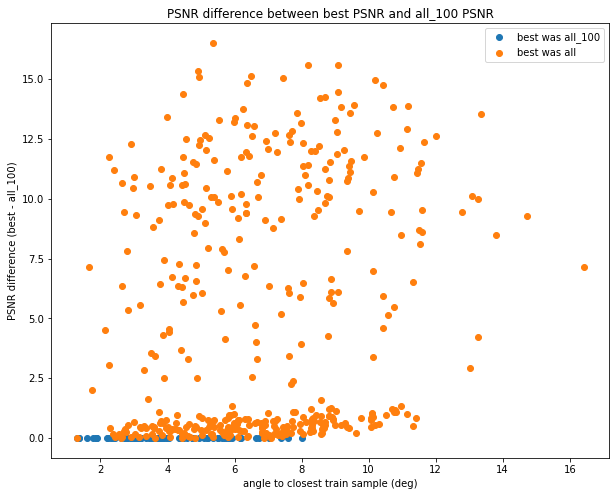

In [160]:
fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot()
# ax = fig.add_subplot(projection='polar')
plt.ylabel("PSNR difference (best - all_100)")
plt.xlabel("angle to closest train sample (deg)")
plt.title("PSNR difference between best PSNR and all_100 PSNR")
x = angles*180/np.pi
y = best_psnr - psnrs[0]
for i, suffix in enumerate(suffixes):
    current_suffix = np.where(best_psnr_idx == i)
    ax.scatter(x[current_suffix],y[current_suffix], label=f"best was {suffix}")

ax.legend()
fig.savefig("/home/ccl/Downloads/plots/PSNR_DIFF_REL.png")

In [167]:
np.argmin(psnrs, axis=1)

array([16,  5])

In [38]:

idx = np.argsort(psnr_filtered, axis=1)
print(equator[0][idx][0])

[379 414 378 413 377 459 412 492 470 458 411 469 471 421 422 493 423 359
 361 391 472 390 362 495 478 381 474 468 494 491 484 419 496 490 363 420
 499 475 436 358 389 485 432 488 405 435 406 497 407 399 498 410 467 473
 445 446 440 392 434 476 455 442 450 448 393 479 415 456 461 489 439 409
 367 371 376 438 462 366 482 433 457 487 424 437 454 460 375 425 430 443
 404 417 403 388 398 486 477 402 400 464 368 418 372 453 401 365 441 374
 447 426 394 395 396 373 369 380 370 416 427 428 481 444 463 408 397 360
 431 483 465 449 429 466 480 452 451]
